# Training a Cellpose model

We will first install cellpose 2.0, check the GPU is working, and get your models and images.

In [2]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob
import napari
from natsort import natsorted

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Mon May 15 09:59:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 30%   44C    P8    34W / 300W |    688MiB / 49140MiB |      8%      Default |
|                               |                      |                  N/A |
+

# Train model on manual annotations

Skip this step if you already have a pretrained model.

Fill out the form below with the paths to your data and the parameters to start training.

## Training parameters

<font size = 4> **Paths for training, predictions and results**


<font size = 4>**`train_dir:`, `test_dir`:** These are the paths to your folders train_dir (with images and masks of training images) and test_dir (with images and masks of test images). You can leave the test_dir blank, but it's recommended to have some test images to check the model's performance. To find the paths of the folders containing the respective datasets, go to your Files on the left of the notebook, navigate to the folder containing your files and copy the path by right-clicking on the folder, **Copy path** and pasting it into the right box below.

<font size = 4>**`initial_model`:** Choose a model from the cellpose [model zoo](https://cellpose.readthedocs.io/en/latest/models.html#model-zoo) to start from.

<font size = 4>**`model_name`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 4>**Training parameters**

<font size = 4>**`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. At least 100 epochs are recommended, but sometimes 250 epochs are necessary, particularly from scratch. **Default value: 100**



In [100]:
base_dir = '/mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/'

In [102]:
# path to training images
train_dir = os.path.join(base_dir, 'training_dir')
# path to test images
test_dir = None #os.path.join(base_dir, 'test_dir') # or None
# Define where the patch file will be saved
base = os.path.join(base_dir, 'patch_files')

# model name and path
initial_model = "cyto" # ['cyto','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4','scratch']
model_name = "macrohet_seg" # if 'scratch' then set to None

# Number of epochs:
n_epochs =  250 

ch1, ch2 = 0,0 # 'Grayscale', None

# Advanced Parameters
Use_Default_Advanced_Parameters = True 
learning_rate = 0.1 
weight_decay = 0.0001 

#here we check that no model with the same name already exist, if so delete
model_path = base_dir#os.path.join(base_dir, 'models')
if os.path.exists(model_path+'/models/'+model_name):
    print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

!! WARNING: macrohet_seg already exists and will be deleted in the following cell !!


## Train new model

Using settings from form above, train model in notebook.

In [103]:
# get files # using their function 
output = io.load_train_test_data(train_dir, test_dir=test_dir, mask_filter='_gt_inst_masks')
train_data, train_labels, _, test_data, test_labels, _ = output

2023-05-17 09:54:59,504 [INFO] not all flows are present, running flow generation for all images
2023-05-17 09:55:00,137 [INFO] 8 / 8 images in /mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/training_dir folder have labels


In [104]:
# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# set channels
channels = [ch1, ch2]

#traing
new_model_path = model.train(train_data, 
                             train_labels, 
                             test_data=test_data,
                             test_labels=test_labels,
                             channels=channels, 
                             save_path=model_path, 
                             n_epochs=n_epochs,
                             learning_rate=learning_rate, 
                             weight_decay=weight_decay, 
                             nimg_per_epoch=8,
                             model_name=model_name)

# diameter of labels in training images
diam_labels = model.diam_labels.copy()

2023-05-17 09:55:13,320 [INFO] WRITING LOG OUTPUT TO /home/dayn/.cellpose/run.log
2023-05-17 09:55:13,327 [INFO] >> cyto << model set to be used
2023-05-17 09:55:13,348 [INFO] ** TORCH CUDA version installed and working. **
2023-05-17 09:55:13,350 [INFO] >>>> using GPU
2023-05-17 09:55:13,510 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2023-05-17 09:55:29,024 [INFO] computing flows for labels



100%|███████████████████████████████████████████████████████████████████████| 8/8 [10:33<00:00, 79.14s/it]


2023-05-17 10:06:12,448 [INFO] >>>> median diameter set to = 30
2023-05-17 10:06:12,449 [INFO] >>>> mean of training label mask diameters (saved to model) 188.440
2023-05-17 10:06:12,451 [INFO] >>>> training network with 2 channel input <<<<
2023-05-17 10:06:12,451 [INFO] >>>> LR: 0.10000, batch_size: 8, weight_decay: 0.00010
2023-05-17 10:06:12,452 [INFO] >>>> ntrain = 8
2023-05-17 10:06:12,453 [INFO] >>>> nimg_per_epoch = 8
2023-05-17 10:06:16,110 [INFO] Epoch 0, Time  3.7s, Loss 1.0681, LR 0.0000
2023-05-17 10:06:18,849 [INFO] saving network parameters to /mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/models/macrohet_seg
2023-05-17 10:06:31,487 [INFO] Epoch 5, Time 19.0s, Loss 1.1894, LR 0.0556
2023-05-17 10:06:47,624 [INFO] Epoch 10, Time 35.2s, Loss 1.0486, LR 0.1000
2023-05-17 10:07:18,390 [INFO] Epoch 20, Time 65.9s, Loss 1.0370, LR 0.1000
2023-05-17 10:07:49,052 [INFO] Epoch 30, Time 96.6s, Loss 0.9673, LR 0.1000
2023-05-17 10:08:20,608 [INFO] Epoch 40, 

# Notify

In [105]:
from macrohet.notify import send_sms

In [106]:
send_sms('traing comlpet')

2023-05-17 10:19:01,375 [INFO] -- BEGIN Twilio API Request --
2023-05-17 10:19:01,376 [INFO] POST Request: https://api.twilio.com/2010-04-01/Accounts/AC5c24c3260ed6b1c8289de1897f4e5b39/Messages.json
2023-05-17 10:19:01,377 [INFO] Headers:
2023-05-17 10:19:01,378 [INFO] User-Agent : twilio-python/7.16.1 (Linux x86_64) Python/3.9.12
2023-05-17 10:19:01,379 [INFO] X-Twilio-Client : python-7.16.1
2023-05-17 10:19:01,379 [INFO] Accept-Charset : utf-8
2023-05-17 10:19:01,380 [INFO] Content-Type : application/x-www-form-urlencoded
2023-05-17 10:19:01,380 [INFO] Accept : application/json
2023-05-17 10:19:01,381 [INFO] -- END Twilio API Request --
2023-05-17 10:19:01,917 [INFO] Response Status Code: 201
2023-05-17 10:19:01,919 [INFO] Response Headers: {'Date': 'Wed, 17 May 2023 09:19:01 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '818', 'Connection': 'keep-alive', 'Twilio-Request-Id': 'RQ0cda6ab1973385b86a1132ecd48cf68f', 'Twilio-Request-Duration': '0.131', 'Acces

## Evaluate on test data (optional)

If you have test data, check performance

# 500 epochs on 6 training images, 3700 cells, TESTING ON 2 IMAGES

In [87]:
# get files (during training, test_data is transformed so we will load it again)
# output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
# test_data = [io.imread(fn) for fn in natsorted(glob(os.path.join(test_dir, 'raw_images/')))]
# test_labels = [io.imread(fn) for fn in natsorted(glob(os.path.join(test_dir, 'ground_truth_inst/*')))]
# test_data = [io.imread('/mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/test_dir/raw_images/r06c09f0*p0*-ch1sk1fk1fl1.tiff')]
# test_labels = [io.imread('/mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/test_dir/ground_truth_inst/gt_inst_r06c09f0*p0*-ch1sk1fk1fl1.tiff')]
# run model on test images
masks = model.eval(test_data, 
                   channels=[chan, chan2],
                   diameter=diam_labels)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


2023-05-16 15:22:15,254 [INFO] 100%|##########| 2/2 [02:42<00:00, 81.48s/it]

>>> average precision at iou threshold 0.5 = 0.894


# 250 epochs

In [61]:
# get files (during training, test_data is transformed so we will load it again)
# output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
# test_data = [io.imread(fn) for fn in natsorted(glob(os.path.join(test_dir, 'raw_images/')))]
# test_labels = [io.imread(fn) for fn in natsorted(glob(os.path.join(test_dir, 'ground_truth_inst/*')))]
test_data = [io.imread('/mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/test_dir/raw_images/r06c09f0*p0*-ch1sk1fk1fl1.tiff')]
test_labels = [io.imread('/mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/test_dir/ground_truth_inst/gt_inst_r06c09f0*p0*-ch1sk1fk1fl1.tiff')]
# run model on test images
masks = model.eval(test_data, 
                   channels=[chan, chan2],
                   diameter=diam_labels)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')



>>> average precision at iou threshold 0.5 = 0.899


# 10 epochs

In [53]:
# get files (during training, test_data is transformed so we will load it again)
# output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
# test_data = [io.imread(fn) for fn in natsorted(glob(os.path.join(test_dir, 'raw_images/')))]
# test_labels = [io.imread(fn) for fn in natsorted(glob(os.path.join(test_dir, 'ground_truth_inst/*')))]
test_data = [io.imread('/mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/test_dir/raw_images/r06c09f0*p0*-ch1sk1fk1fl1.tiff')]
test_labels = [io.imread('/mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/test_dir/ground_truth_inst/gt_inst_r06c09f0*p0*-ch1sk1fk1fl1.tiff')]
# run model on test images
masks = model.eval(test_data, 
                   channels=[chan, chan2],
                   diameter=diam_labels)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')



>>> average precision at iou threshold 0.5 = 0.884


# 10k epochs

In [66]:
# get files (during training, test_data is transformed so we will load it again)
# output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
# test_data = [io.imread(fn) for fn in natsorted(glob(os.path.join(test_dir, 'raw_images/')))]
# test_labels = [io.imread(fn) for fn in natsorted(glob(os.path.join(test_dir, 'ground_truth_inst/*')))]
test_data = [io.imread('/mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/test_dir/raw_images/r06c09f0*p0*-ch1sk1fk1fl1.tiff')]
test_labels = [io.imread('/mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/test_dir/ground_truth_inst/gt_inst_r06c09f0*p0*-ch1sk1fk1fl1.tiff')]
# run model on test images
masks = model.eval(test_data, 
                   channels=[chan, chan2],
                   diameter=diam_labels)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')



>>> average precision at iou threshold 0.5 = 0.868


In [70]:
epoch_score_dict = {10:0.884, 250:0.899, 10000:0.868}

In [67]:
from macrohet import notify

In [68]:
notify.send_sms('training complete')

2023-05-13 02:16:18,840 [INFO] -- BEGIN Twilio API Request --
2023-05-13 02:16:18,841 [INFO] POST Request: https://api.twilio.com/2010-04-01/Accounts/AC5c24c3260ed6b1c8289de1897f4e5b39/Messages.json
2023-05-13 02:16:18,841 [INFO] Headers:
2023-05-13 02:16:18,842 [INFO] User-Agent : twilio-python/7.16.1 (Linux x86_64) Python/3.9.12
2023-05-13 02:16:18,842 [INFO] X-Twilio-Client : python-7.16.1
2023-05-13 02:16:18,842 [INFO] Accept-Charset : utf-8
2023-05-13 02:16:18,843 [INFO] Content-Type : application/x-www-form-urlencoded
2023-05-13 02:16:18,843 [INFO] Accept : application/json
2023-05-13 02:16:18,843 [INFO] -- END Twilio API Request --
2023-05-13 02:16:19,378 [INFO] Response Status Code: 201
2023-05-13 02:16:19,380 [INFO] Response Headers: {'Date': 'Sat, 13 May 2023 01:16:19 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '821', 'Connection': 'keep-alive', 'Twilio-Request-Id': 'RQc1736ba19fcb2ea9ce9acc08649c1c06', 'Twilio-Request-Duration': '0.151', 'Acces

plot masks

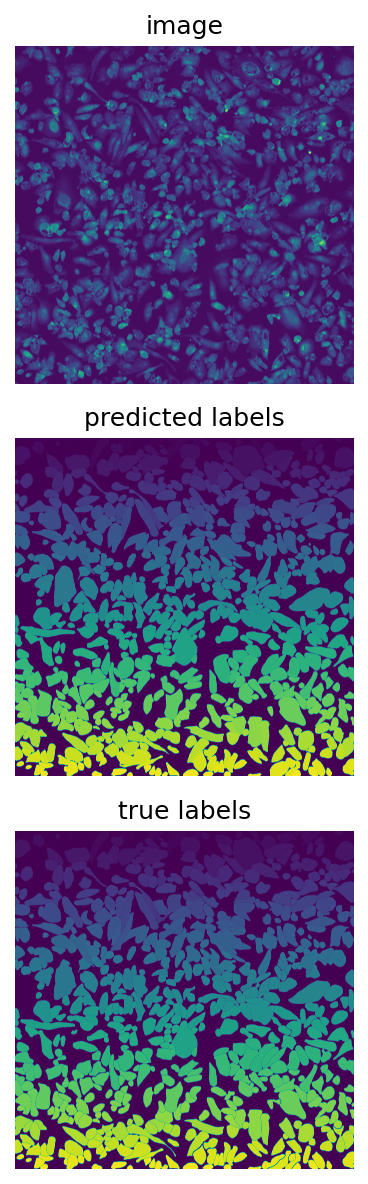

In [62]:

plt.figure(figsize=(12,8), dpi=150)
for k,im in enumerate(test_data):
    img = im.copy()
    plt.subplot(3,len(train_files), k+1)
    img = np.vstack((img, np.zeros_like(img)[:1]))
#     img = img.transpose(1,2,0)
    plt.imshow(img)
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(train_files), len(train_files) + k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(train_files), 2*len(train_files) + k+1)
    plt.imshow(test_labels[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()

# Use custom model to segment images

Take custom trained model from above, or upload your own model to google drive / colab runtime.

## Parameters

In [88]:
model_path

'/mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/models'

In [ ]:
# model name and path

#@markdown ###Custom model path (full path):

model_path = "human_in_the_loop/train/models/CP_tissuenet" #@param {type:"string"}

#@markdown ###Path to images:

dir = "human_in_the_loop/test" #@param {type:"string"}

#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Green" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown If you have a secondary channel that can be used, for instance nuclei, choose it here:

Second_segmentation_channel= "Red" #@param ["None", "Blue", "Green", "Red"]


# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1


if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

#@markdown ### Segmentation parameters:

#@markdown diameter of cells (set to zero to use diameter from training set):
diameter =  0#@param {type:"number"}
#@markdown threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 #@param {type:"slider", min:0.0, max:3.0, step:0.1}
#@markdown threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}


if you're using the example test data we'll copy it to a new folder

In [ ]:
src = 'human_in_the_loop/test'
if dir[:len(src)] == src:
    files = io.get_image_files(dir, '_masks')
    dir = 'human_in_the_loop/eval/'
    os.makedirs(dir, exist_ok=True)
    for f in files:
        dst = dir + os.path.split(f)[1]
        print(f'{f} > {dst}')
        shutil.copyfile(f, dst)

human_in_the_loop/test/breast_vectra_0.tif > human_in_the_loop/eval/breast_vectra_0.tif
human_in_the_loop/test/img_1213.tif > human_in_the_loop/eval/img_1213.tif
human_in_the_loop/test/img_1220.tif > human_in_the_loop/eval/img_1220.tif


Here's what the command to train would be on the command line -- make sure if you run this locally to correct the paths for your local computer.

In [ ]:
run_str = f'python -m cellpose --use_gpu --verbose --dir {dir} --pretrained_model {model_path} --chan {chan} --chan2 {chan2} --diameter {diameter} --flow_threshold {flow_threshold} --cellprob_threshold {cellprob_threshold}'
print(run_str)

python -m cellpose --use_gpu --verbose --dir human_in_the_loop/eval/ --pretrained_model human_in_the_loop/train/models/CP_tissuenet --chan 2 --chan2 1 --diameter 0 --flow_threshold 0.4 --cellprob_threshold 0


## run custom model

how to run the custom model in a notebook

In [ ]:
# gets image files in dir (ignoring image files ending in _masks)
files = io.get_image_files(dir, '_masks')
print(files)
images = [io.imread(f) for f in files]

# declare model
model = models.CellposeModel(gpu=True, 
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

# run model on test images
masks, flows, styles = model.eval(images, 
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )

['human_in_the_loop/eval/breast_vectra_0.tif', 'human_in_the_loop/eval/img_1213.tif', 'human_in_the_loop/eval/img_1220.tif']
2022-04-30 23:52:29,909 [INFO] >>>> loading model human_in_the_loop/train/models/CP_tissuenet
2022-04-30 23:52:29,911 [INFO] ** TORCH CUDA version installed and working. **
2022-04-30 23:52:29,913 [INFO] >>>> using GPU
2022-04-30 23:52:30,084 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2022-04-30 23:52:30,085 [INFO] >>>> model diam_labels =  19.259 (mean diameter of training ROIs)
2022-04-30 23:52:31,072 [INFO] 100%|##########| 3/3 [00:00<00:00,  3.05it/s]


## save output to *_seg.npy

you will see the files save in the Files tab and you can download them from there

In [ ]:
from cellpose import io

io.masks_flows_to_seg(images, 
                      masks, 
                      flows, 
                      diameter*np.ones(len(masks)), 
                      files, 
                      [chan, chan2])

## save output masks to tiffs/pngs or txt files for imageJ

In [ ]:
io.save_masks(images, 
              masks, 
              flows, 
              files, 
              channels=[chan, chan2],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs 
              )
    

(-0.5, 3599.5, 899.5, -0.5)

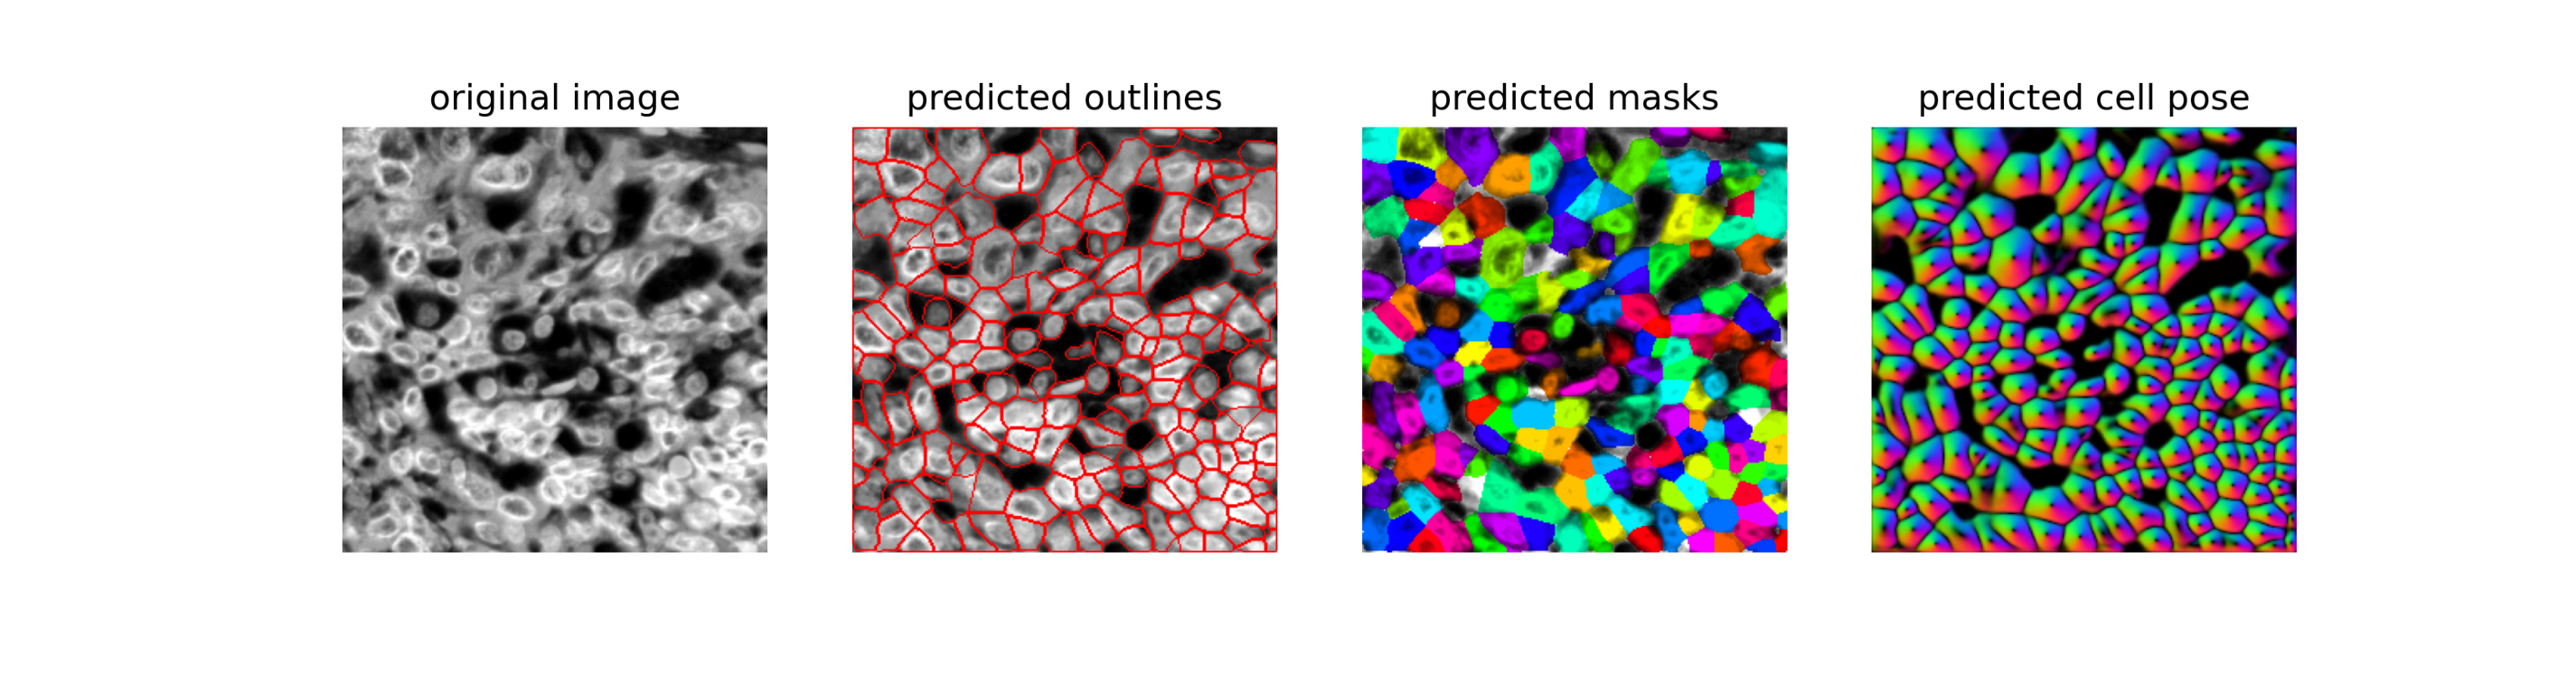

In [ ]:
f = files[0]
plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread(os.path.splitext(f)[0] + '_cp_output.png'))
plt.axis('off')